# DTER Object Detection On Multi-Mnist Dataset
1. This notebook uses models folder from [original git repo](https://github.com/facebookresearch/detr) 
2. The MMnist dataloader is taken from [this git repo](https://github.com/tohinz/multiple-objects-gan/blob/master/code/multi-mnist/miscc/datasets.py)
3. Dataset can be downloaded from [here](https://www2.informatik.uni-hamburg.de/wtm/software/multiple-objects-gan/data-multi-mnist.zip)

## 1. Declaration of required packages

In [1]:
import json
import random
import torch
import os
import datasets
import numpy as np
from models import build_model
from utils import collate_fn,Logger
from torch.utils.data import DataLoader
from datasets import build_dataset
from utils import AverageMeter,challenge_metric,show_predictions
from tqdm.notebook import tqdm

## 2. Experiment configuration settings

In [2]:
def get_args():
    
    class config(object):
        
        def __init__(self):
            self.exp_name            = 'exp_res_50_enc_6'
            self.lr                  = 1e-4   
            self.lr_backbone         = 1e-5    
            self.batch_size          = 32      
            self.weight_decay        = 1e-4    
            self.epochs              = 300
            self.lr_drop             = 200
            self.clip_max_norm       = 0.1
            self.infr_model          = 'detr_best_exp_res_50_enc_6.pth' 

            #Backbone
            self.backbone            = 'resnet50'      # Name of the convolutional backbone to use
            self.dilation            = True            # If true, we replace stride with dilation in the last convolutional block (DC5)
            self.position_embedding  ='sine'           # Type of positional embedding to use on top of the image features
            self.num_classes         = 10              # Number of classes for DETR model without background class



            # * Transformer
            self.enc_layers          = 6               # Number of encoding layers in the transformer       
            self.dec_layers          = 6               # Number of decoding layers in the transformer
            self.dim_feedforward     = 2048            # Intermediate size of the feedforward layers in the 
                                                       #                               transformer blocks
            self.hidden_dim          = 256             # Size of the embeddings (dimension of the transformer)

            self.dropout             = 0.1             # Dropout applied in the transformer
            self.nheads              = 8               # Number of attention heads inside the transformer's attentions)
            self.num_queries         = 3               # Number of query slots
            self.pre_norm            = True


            # * Matcher
            self.set_cost_class      = 1              # Class coefficient in the matching cost)
            self.set_cost_bbox       = 5              # L1 box coefficient in the matching cost)
            self.set_cost_giou       = 2              # giou box coefficient in the matching cost)


            # * Loss coefficients 
            self.bbox_loss_coef      = 5
            self.giou_loss_coef      = 2
            self.eos_coef            =0.1             # Relative classification weight of the no-object clasself    

            # dataset parameters
            self.dataset_path       = './datasets'
            self.dataset_file       = 'mmnist'

            self.output_dir         = './{}'.format(self.exp_name)
            self.device             = 0               # device to use for training / testing

            self.seed               = 42
            self.num_workers        = 2
    
    return config()

## 3. Defining Engine

In [3]:
# function to train the model for one epoch
def train_fn(data_loader,model,criterion,optimizer,device,scheduler,epoch,args):
    model.train()
    criterion.train()
    
    tk0 = tqdm(data_loader, total=len(data_loader),leave=False,desc='Epoch trn:{}/{}'.format(epoch,args.epochs))
    log = None
    
    for step, (images, targets, image_ids) in enumerate(tk0):
        
        batch_size = len(images)
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        

        output = model(images)
        
        loss_dict = criterion(output, targets)

        
        if log is None:
            log = {k:AverageMeter() for k in loss_dict}
            log['total_loss'] = AverageMeter()
            log['mAP'] = AverageMeter()
            
        weight_dict = criterion.weight_dict
        total_loss = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        
        optimizer.zero_grad()
        total_loss.backward()
        
        if args.clip_max_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip_max_norm )
        
        optimizer.step()
        
        log['total_loss'].update(total_loss.item(),batch_size)
        
        for k,v in loss_dict.items():
            log[k].update(v.item(),batch_size)
        
        log['mAP'].update(challenge_metric(output,targets,'mAP'),batch_size)
        tk0.set_postfix({k:v.avg for k,v in log.items()}) 
        
        
    return log


# function to validate the model on validation set
def eval_fn(data_loader, model,criterion, device,epoch,args):
    model.eval()
    criterion.eval()
    log = None
    
    with torch.no_grad():
        
        tk0 = tqdm(data_loader, total=len(data_loader),leave=False,desc='Epoch val:{}/{}'.format(epoch,args.epochs))
        for step, (images, targets, image_ids) in enumerate(tk0):
            
            batch_size = len(images)
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            output = model(images)
        
            loss_dict = criterion(output, targets)
            weight_dict = criterion.weight_dict
            

            if log is None:
                log = {k:AverageMeter() for k in loss_dict}
                log['total_loss'] = AverageMeter()
                log['mAP'] = AverageMeter()
                
            for k,v in loss_dict.items():
                log[k].update(v.item(),batch_size)

            total_loss = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
            log['total_loss'].update(total_loss.item(),batch_size)
            log['mAP'].update(challenge_metric(output,targets,'mAP'),batch_size)
            tk0.set_postfix({k:v.avg for k,v in log.items()})
            

    return log 


# function to perform inference on test set
def inference_fn(data_loader, model, device,args):
    model.eval()
    images, targets, image_ids = next(iter(data_loader))
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]


    with torch.no_grad():
        output = model(images)
        show_predictions(images,output,targets)

def inference(args):
    device = torch.device('cuda:'+str(args.device)) 
    model, criterion = build_model(args)
    model.to(device)
    infr_wts = torch.load(os.path.join(args.output_dir,args.infr_model),map_location=device)
    model.load_state_dict(infr_wts)
    dataset_val = build_dataset(split='test', args=args)
    data_loader_val = DataLoader(dataset_val, batch_size=1,num_workers=args.num_workers,drop_last=False,shuffle=True,collate_fn=collate_fn)
    inference_fn(data_loader_val, model, device,args)

## 4.Main Function

In [4]:
def main(args):
    
    # experiment settings
    device = torch.device('cuda:'+str(args.device)) 
    seed = args.seed
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    #initializing model based on args
    model, criterion = build_model(args)
    
    # setting the learning rate for different components
    n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('number of params:', n_parameters)

    param_dicts = [
        {"params": [p for n, p in model.named_parameters() if "backbone" not in n and p.requires_grad]},
        {
            "params": [p for n, p in model.named_parameters() if "backbone" in n and p.requires_grad],
            "lr": args.lr_backbone,
        },
    ]

    model.to(device)
    
    #loss function
    criterion = criterion.to(device)
    
    #optimizer
    optimizer = torch.optim.AdamW(param_dicts, lr=args.lr,weight_decay=args.weight_decay)

    
    #initializing logger
    os.makedirs(args.output_dir,exist_ok=True)
    logger = Logger(os.path.join(args.output_dir,'log_{}'.format(args.exp_name)))
    dataset_train = build_dataset(split='train', args=args)
    dataset_val = build_dataset(split='test', args=args)
    
    #initializing dataloader
    data_loader_train = DataLoader(dataset_train, batch_size=args.batch_size,num_workers=args.num_workers,drop_last=True,shuffle=True,collate_fn=collate_fn)
    data_loader_val = DataLoader(dataset_val, batch_size=args.batch_size,num_workers=args.num_workers,drop_last=False,shuffle=False,collate_fn=collate_fn)
    
    header_printed = False
    best_precision = 0
    
    #epoch training starts
    epoch_val_loss_total = []
    epoch_mAP =[]
    
    for epoch in range(args.epochs):
        train_log = train_fn(data_loader_train, model,criterion, optimizer,device,scheduler=None,epoch=epoch,args=args)
        valid_log = eval_fn(data_loader_val, model,criterion, device,epoch,args)
        
        log = {k:v.avg for k,v in valid_log.items()}
        log.update({k:v.avg for k,v in valid_log.items()})
        
        logger.save(log,epoch)
        keys = sorted(log.keys())
        
        epoch_val_loss_total.append(log['total_loss'])
        epoch_mAP.append(log['mAP'])
        
        if not header_printed:
            print(' '.join(map(lambda k: f'{k[:8]:8}',keys)))
            header_printed = True
        print(' '.join(map(lambda k: f'{log[k]:8.3f}'[:8],keys)))
        
        # best model is saved based on mAP metric
        if log['mAP'] > best_precision:
            best_precision = log['mAP']
            print('Best model found at epoch {}'.format(epoch+1))
            torch.save(model.state_dict(), os.path.join(args.output_dir,f'detr_best_{args.exp_name}.pth'))
            inference(get_args())

## 6. Start of Training

number of params: 41257231


cardinal class_er epoch    loss_bbo loss_ce  loss_gio mAP      total_lo
   0.000   64.987    1.000    0.127    1.772    0.448    0.230    3.304
Best model found at epoch 1


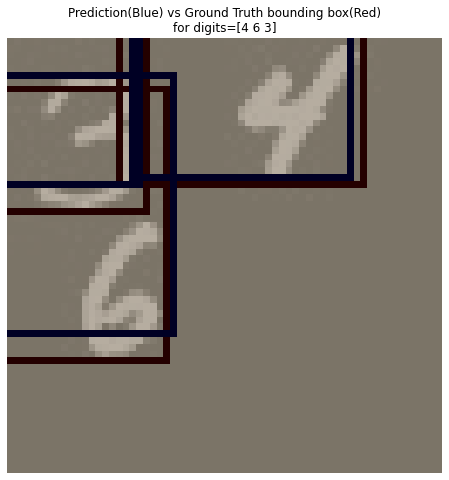

   0.000   32.763    2.000    0.091    0.900    0.350    0.369    2.053
Best model found at epoch 2


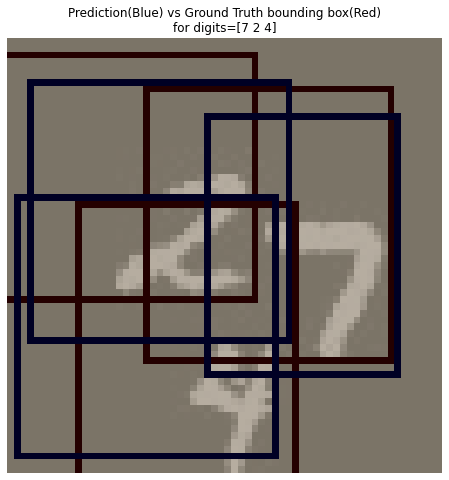

   0.000   23.790    3.000    0.077    0.670    0.302    0.419    1.657
Best model found at epoch 3


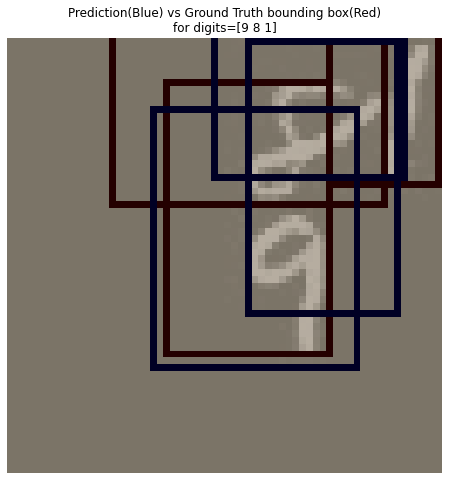

   0.000   19.397    4.000    0.065    0.553    0.262    0.424    1.402
Best model found at epoch 4


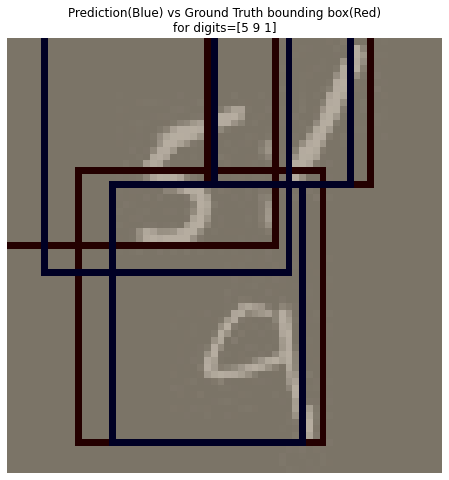

   0.000   17.490    5.000    0.060    0.505    0.235    0.461    1.274
Best model found at epoch 5


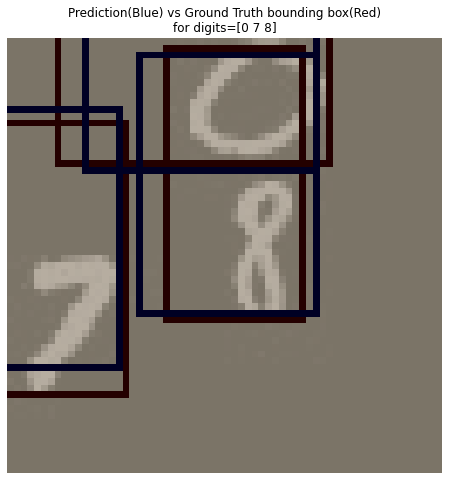

   0.000   14.483    6.000    0.055    0.427    0.222    0.470    1.148
Best model found at epoch 6


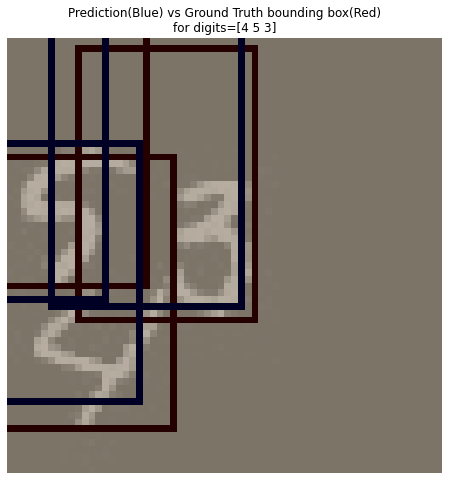

   0.000   14.977    7.000    0.059    0.439    0.240    0.388    1.215


   0.000   13.457    8.000    0.055    0.398    0.227    0.440    1.125


   0.000   12.650    9.000    0.052    0.378    0.211    0.499    1.062
Best model found at epoch 9


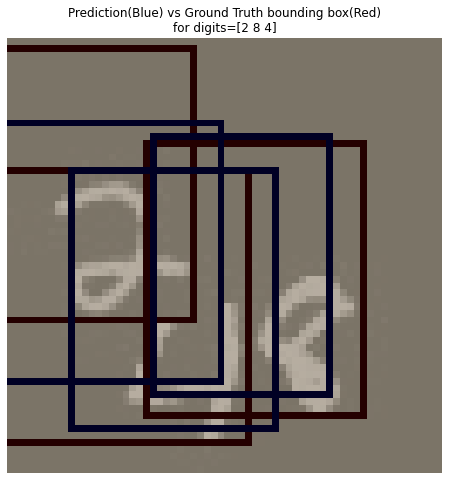

In [ ]:
main(get_args())